# Trends in Anime & Manga

## Load data

In [1]:
from mangaki.algo.dataset import Dataset
from mangaki.algo.fit_algo import get_dataset_backup
from mangaki.utils.values import rating_values

dataset = Dataset()
dataset.load_csv('balse/ratings.csv', convert=lambda x: rating_values[x], title_filename='balse/works.csv')

In [2]:
from mangaki.algo.balse import MangakiBALSE
from mangaki.settings import DATA_DIR
from scipy.sparse import load_npz

In [3]:
import os.path
import numpy as np

T = load_npz(os.path.join(DATA_DIR, 'balse/tag-matrix.npz'))

In [4]:
T

<9979x503 sparse matrix of type '<class 'numpy.float64'>'
	with 210009 stored elements in Compressed Sparse Row format>

In [5]:
import json
tags = json.load(open('../data/illustration2vec/mangaki_i2v.json'))

In [6]:
tags['1.jpg']

{'general': [['1girl', 0.5351361632347107],
  ['1boy', 0.5314481258392334],
  ['black hair', 0.4160270392894745],
  ['short hair', 0.4073851704597473],
  ['blue eyes', 0.2690363824367523],
  ['multiple boys', 0.16339154541492462],
  ['weapon', 0.16306668519973755],
  ['long hair', 0.16088248789310455],
  ['2boys', 0.15612725913524628],
  ['male', 0.1489870250225067],
  ['brown hair', 0.13320335745811462],
  ['scan', 0.11500567942857742],
  ['2girls', 0.10508275777101517]],
 'character': [],
 'copyright': [],
 'rating': [['safe', 0.9664666652679443],
  ['questionable', 0.0323437824845314],
  ['explicit', 0.00026572716888040304]]}

In [7]:
work_ids = list(Work.objects.values_list('id', flat=True))
encode_work = dict(zip(work_ids, range(len(work_ids))))
decode_work = {v: k for k, v in encode_work.items()}

In [8]:
all_tags = set()
for _, value in tags.items():
    for tag, _ in value['general']:
        all_tags.add(tag)
print(len(all_tags))

503


In [9]:
encode_tag = dict(zip(list(all_tags), range(len(all_tags))))
decode_tag = {v: k for k, v in encode_tag.items()}

In [10]:
data = []
rows = []
cols = []

In [11]:
from scipy.sparse import coo_matrix

In [12]:
for work_id in range(len(encode_work)):
    poster = '{:d}.jpg'.format(work_id)
    if poster in tags:
        for tag, value in tags[poster]['general']:
            rows.append(work_id)
            cols.append(encode_tag[tag])
            data.append(value)

In [13]:
len(rows), len(cols), len(data)

(307075, 307075, 307075)

In [14]:
T = coo_matrix((data, (rows, cols))).tocsr()

In [15]:
T

<12817x503 sparse matrix of type '<class 'numpy.float64'>'
	with 307075 stored elements in Compressed Sparse Row format>

In [16]:
from scipy.sparse import save_npz

save_npz('tags2018.npz', T)

In [17]:
Work.objects.get(id=1346).date.month

6

In [18]:
Work.objects.count()

16796

In [19]:
Work.objects.filter(date__isnull=False).count()

12624

In [20]:
max_encoded = T.shape[0]

In [21]:
from collections import Counter, defaultdict

In [29]:
trends = defaultdict(Counter)
popular = defaultdict(Counter)

In [30]:
for year in range(2000, 2019):
    ids = Work.objects.filter(date__year=year).values_list('id', flat=True).popular()
    print(len(ids), 'in', year)
    encoded = [encode_work[work_id] for work_id in ids if encode_work[work_id] < max_encoded]
    weights = T[encoded].mean(axis=0).A1
    weights2 = T[encoded[:50]].mean(axis=0).A1
    trends[year] = Counter(dict(zip(decode_tag.values(), weights)))
    popular[year] = Counter(dict(zip(decode_tag.values(), weights2)))

217 in 2000
349 in 2001
343 in 2002
395 in 2003
427 in 2004
446 in 2005
504 in 2006
493 in 2007
501 in 2008
546 in 2009
549 in 2010
617 in 2011
658 in 2012
652 in 2013
741 in 2014
730 in 2015
493 in 2016
320 in 2017
139 in 2018


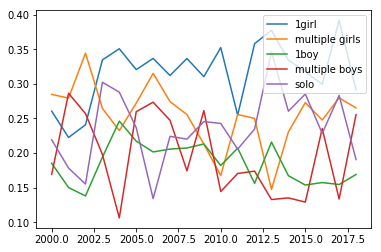

In [36]:
import matplotlib.pyplot as plt

# interesting = ['1girl', 'multiple girls', '1boy', 'multiple boys', 'solo', 'short hair', 'long hair', 'blonde hair']
interesting = ['1girl', 'multiple girls', '1boy', 'multiple boys', 'solo']
years = range(2000, 2019)

ax = plt.subplot(111)
for tag in interesting:
    plt.plot(years, [popular[year][tag] for year in years], label=tag)

plt.legend()
#leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
#leg.get_frame().set_alpha(0.5)


plt.show()

In [37]:
performer = Counter()

for tag in all_tags:
    for year in range(2005, 2015):
        performer[tag] += abs(trends[year][tag] - trends[year - 1][tag])

In [38]:
performer.most_common(20)

[('1girl', 0.2423617688245796),
 ('solo', 0.21679440158562094),
 ('multiple girls', 0.21360942023217894),
 ('1boy', 0.17883022408636914),
 ('brown hair', 0.15948363945518376),
 ('red hair', 0.15740664805737725),
 ('school uniform', 0.15301911138722404),
 ('black hair', 0.13427295391641358),
 ('blue hair', 0.13193226431427715),
 ('breasts', 0.12835214056855682),
 ('blonde hair', 0.127904875969778),
 ('6+girls', 0.10539020168310947),
 ('brown eyes', 0.10447416588166036),
 ('open mouth', 0.10430087209069533),
 ('short hair', 0.10365397457312392),
 ('multiple boys', 0.10195656762683869),
 ('blush', 0.10007566893056125),
 ('glasses', 0.09947027753818952),
 ('underwear', 0.09936063911499088),
 ('male', 0.09684066599388592)]